## TP géométrie épipolaire et rectification stéréo

Guillaume Bourmaud

L'objectif de ce TP est d'estimer, à partir d'une paire d'images ($\mathbf{I}_A, \mathbf{I}_B$)  (voir ci-dessous), la matrice fondamentale $\mathbf{F}_{AB}$ en implémentant une méthode de RANSAC utilisant l'algorithme des 8 correspondances. L'archive contenant la paire d'images est disponible [ici](https://gbourmaud.github.io/files/vision/TP/TP_rectification_stereo/data.zip).  


$\mathbf{I}_A$             |  $\mathbf{I}_B$
:-------------------------:|:-------------------------:
![](data/1.png)  |  ![](data/3.png)

La matrice fondamentale $\mathbf{F}_{AB}$ sera ensuite utilisée pour effectuer une **rectification stéréo** de cette paire d'images. Le résultat obtenu est donc une paire d'images stéréo (voir ci-dessous), c'est-à-dire une paire d'images où le correspondant d'un point dans une image se situe sur la même ligne dans l'autre image.

$\mathbf{I}_{A,\text{rect}}$             |  $\mathbf{I}_{B,\text{rect}}$ 
:-------------------------:|:-------------------------:
![](imA_rect.png)  |  ![](imB_rect.png)

## Mise en correspondance automatique

L'étape de mise en correspondance automatique sera la même que celle du [TP mosaïque d'images aériennes](https://github.com/gbourmaud/gbourmaud.github.io/blob/master/files/vision/TP/TP_mosaique_aerienne/TP_MOSAIQUE_AERIENNE.ipynb).

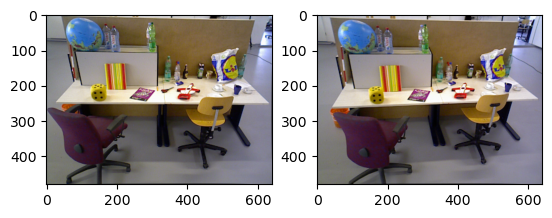

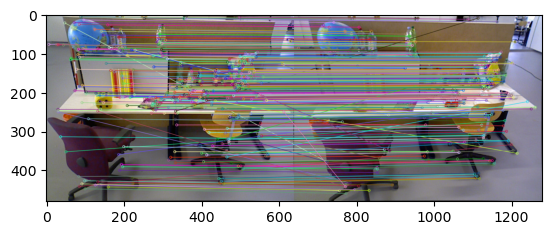

In [2]:
from PIL import Image
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

#%% LOAD IMAGES
I_A = np.array(Image.open('data/1.png'))
I_B = np.array(Image.open('data/3.png'))

I_A_float = I_A.astype(float)/255.
I_B_float = I_B.astype(float)/255.

fig1, axs1 = plt.subplots(1,2)
axs1[0].imshow(I_A);
axs1[1].imshow(I_B);



#%% SIFT & MATCHING

I_A_grey = ((I_A_float.sum(axis=2)/3)*255).astype(np.uint8)
I_B_grey = ((I_B_float.sum(axis=2)/3)*255).astype(np.uint8)

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kpA, desA = sift.detectAndCompute(I_A_grey,None)
pts_A = cv.KeyPoint_convert(kpA)
kpB, desB = sift.detectAndCompute(I_B_grey,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(desA,desB,k=2)
# Apply ratio test
good = []
for m,n in matches:
 if m.distance < 0.75*n.distance:
     good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
fig1, ax1 = plt.subplots(1)
ax1.imshow(cv.drawMatchesKnn(I_A,kpA,I_B,kpB,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
plt.pause(0.01)

nMatches = len(good)
p_A = np.float32([kpA[m[0].queryIdx].pt for m in good])
p_A_hom = np.ones((nMatches,3))
p_A_hom[:,:2] = p_A
p_B = np.float32([kpB[m[0].trainIdx].pt for m in good])
p_B_hom = np.ones((nMatches,3))
p_B_hom[:,:2] = p_B

## Estimation de la matrice fondamentale

À partir des correspondances précédemment établies  $\{(\underline{\mathbf{p}}_{A,i},\underline{\mathbf{p}}_{B,i})\}_{i=1...N_{\text{matches}}}$ il vous est demandé de **coder une fonction `ransacF`** dans le but d'estimer la matrice fondamentale $\mathbf{F}_{AB}$.  Dans un premier temps, vous pouvez utiliser l'implémentation de l'algorithme des 8 correspondances d'OpenCV (`F_AB, _ = cv.findFundamentalMat(p_B_sel, p_A_sel, method=cv.FM_8POINT)`). Le prototype suivant de la fonction `ransacF` est conseillé : `F_AB, mask_inliers, nInliers = ransacF(p_A_hom,p_B_hom,nItRansac,threshRansac)`.  
  
Le code ci-après permet de tester votre fonction en affichant les correspondances jugées correctes par le RANSAC.  
**Remarque : en 500 itérations et avec un seuil de 1.5 pixels, vous devriez avoir plus de 350 correspondances jugées correctes par le RANSAC.**  
**SOLUTION : vous trouverez à la fin de ce fichier une fonction `ransacF` à laquelle vous pourrez vous référer si vous êtes bloqués.**

96 inliers
341 inliers
353 inliers
374 inliers


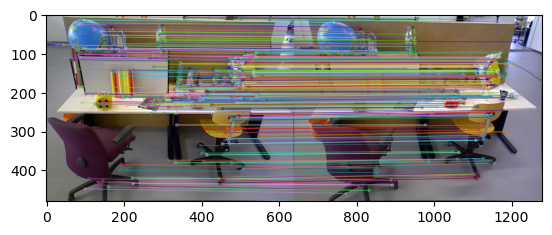

In [11]:
from gui_F import gui_F
from ransacF import ransacF
#%% RANSAC & FUNDAMENTAL MATRIX ESTIMATION

nItRansac = 500
threshRansac = 1.5 #in pixels

F_AB, mask_inliers, nInliers = ransacF(p_A_hom,p_B_hom,nItRansac,threshRansac)

inlier_matches = [good[idx] for idx in np.nonzero(mask_inliers)[0]]
fig2, ax2 = plt.subplots(1)
ax2.imshow(cv.drawMatchesKnn(I_A,kpA,I_B,kpB,inlier_matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
plt.pause(0.01)

p_A_inliers = p_A_hom[mask_inliers,:]
p_B_inliers = p_B_hom[mask_inliers,:]

## Interface graphique
L'interface graphique disponible [ici](https://gbourmaud.github.io/files/vision/TP/TP_rectification_stereo/gui_F.py) permet d'afficher la ligne épipolaire, induite par $\mathbf{F}_{AB}$, correspondante au curseur de votre souris. Vous pouvez ainsi vérifier visuellemement que les lignes épipolaires sont correctes.  

In [ ]:
from gui_F import gui_F
gui_F(Image.fromarray(I_A),Image.fromarray(I_B),F_AB)

## Reconstruction 3D
La fonction `recover_R_T_from_F`, disponible [ici](https://gbourmaud.github.io/files/vision/TP/TP_rectification_stereo/recover_R_T_from_F.py), permet de décomposer la matrice fondamentale $\mathbf{F}_{AB}$ en rotation $\mathbf{R}_{BA}$ et translation $\mathbf{t}_{BA}$. Chaque correspondance $(\underline{\mathbf{p}}_{A,i},\underline{\mathbf{p}}_{B,i})$ (jugée correcte par le RANSAC), peut alors être triangulée, produisant ainsi un point 3D $\mathbf{U}_i^A$. Nous disposons finalement d'un nuage de points 3D (reconstruction 3D parcimonieuse de la scène 3D) et des poses (rotations et translations) des deux caméras dans cette scène. Le calcul et l'affichage des erreurs de reprojection des points 3D est une première manière de valider le code.

[[ 0.99458377  0.04328435 -0.09449651]
 [-0.04283326  0.99905911  0.00679769]
 [ 0.09470183 -0.00271328  0.99550198]]
[[ 0.98922979]
 [-0.05537913]
 [ 0.13549015]]


Text(0.5, 1.0, 'Reproj. err. 0.55 pix')

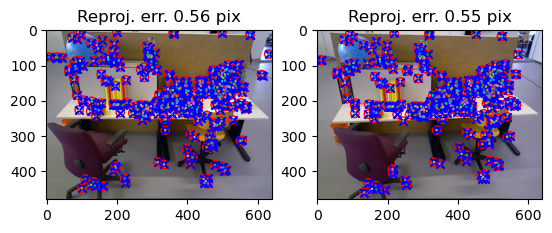

In [12]:
#%% LOAD CAMERA CALIBRATION
K = np.array([[535.4, 0, 320.1], [0, 539.2, 247.6], [0, 0, 1]])

#%% COMPUTE and REFINE R_AB, t_AB and 3D point cloud
from recover_R_T_from_F import recover_R_T_from_F

R_BA, t_BA, maskChirality = recover_R_T_from_F(K, F_AB, p_A_inliers, p_B_inliers)
M_BA = np.eye(4)
M_BA[:3,:3] = R_BA
M_BA[:3,3] = t_BA

p_A_filter = p_A_inliers[maskChirality,:]
p_B_filter = p_B_inliers[maskChirality,:]

P_AW = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P_BW = K @ M_BA[:3,:]
U_A_hom = cv.triangulatePoints(P_AW, P_BW, p_A_filter[:,:2].T, p_B_filter[:,:2].T)
U_A = (U_A_hom[:3,:]/U_A_hom[3,:]).T
assert (U_A[:,2] > 0).all() #all 3D points should have a positive depth in A

p_A_pred = (U_A/U_A[:,2:3]) @ K.T
p_B_pred = ((U_B := (U_A @ R_BA.T) + t_BA)/U_B[:,2:3]) @ K.T

reproj_error_A = (1/p_A_pred.shape[0])*np.sqrt(((p_A_pred - p_A_filter)**2).sum(axis=1)).sum()
reproj_error_B = (1/p_B_pred.shape[0])*np.sqrt(((p_B_pred - p_B_filter)**2).sum(axis=1)).sum()

fig3, axs3 = plt.subplots(ncols=2)
axs3[0].imshow(I_A)
axs3[0].scatter(p_A_filter[:,0], p_A_filter[:,1], marker ='o', facecolors='none', edgecolors='r')
axs3[0].scatter(p_A_pred[:,0], p_A_pred[:,1], marker ='x', color='b')
axs3[0].plot(np.vstack((p_A_filter[:,0],p_A_pred[:,0])), np.vstack((p_A_filter[:,1],p_A_pred[:,1])))
axs3[0].set_title('Reproj. err. {0:0.2f} pix'.format(reproj_error_A))
axs3[1].imshow(I_B)
axs3[1].scatter(p_B_filter[:,0], p_B_filter[:,1], marker ='o', facecolors='none', edgecolors='r')
axs3[1].scatter(p_B_pred[:,0], p_B_pred[:,1], marker ='x', color='b')
axs3[1].plot(np.vstack((p_B_filter[:,0],p_B_pred[:,0])), np.vstack((p_B_filter[:,1],p_B_pred[:,1])))
axs3[1].set_title('Reproj. err. {0:0.2f} pix'.format(reproj_error_B))


## Affichage 3D
Le nuage de points 3D et les poses des caméras peuvent être affichés en 3D en utilisant la bibliothèque Open3D. Ceci constitue une seconde manière de valider le code de reconstruction précédent. La fonction `show3dScene`, disponible [ici](https://gbourmaud.github.io/files/vision/TP/TP_rectification_stereo/show3dScene.py), permet de réaliser une tel affichage.

In [15]:
#%% Show 3D scenes
from show3dScene import show3dScene
viz = show3dScene(U_A, [K, K], [I_A_float, I_B_float], [np.eye(4), M_BA])

![](reconstruction3D.png)

## Rectification stéréo

La fonction `computeHomographyRectification`, disponible [ici](https://gbourmaud.github.io/files/vision/TP/TP_rectification_stereo/computeHomographyRectification.py), calcule, à partir de la pose relative entre les deux caméras (rotation $\mathbf{R}_{BA}$ et translation $\mathbf{t}_{BA}$) les deux rotations $\mathbf{R}_{nA}$ et $\mathbf{R}_{nB}$ permettant d'aligner les deux caméras pour obtenir une paire stéréo. Dans l'illustration suivante, les poses des caméras avant rectification sont tracées en rouge, alors que les poses des caméras après rectification sont tracées en noir. On remarque que les centres optiques n'ont pas bougé car la rectification stereo applique simplement une rotation à chaque caméra pour que les poses résultantes forment une paire stéréo.  
![](illustration_rectif_stereo.png)

La fonction `stereoRectifyImages`, disponible [ici](https://gbourmaud.github.io/files/vision/TP/TP_rectification_stereo/stereoRectifyImages.py) permet d'appliquer les deux homographies.

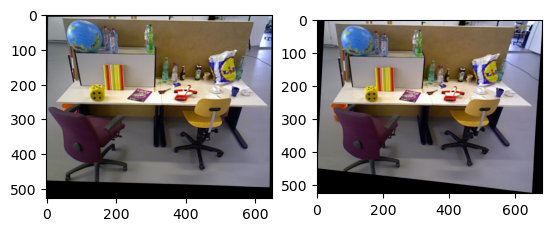

In [18]:
#%% COMPUTE HOMOGRAPHY RECTIFICATION
from computeHomographyRectification import computeHomographyRectification
HnewA_A, HnewB_B, RnewA_A, RnewB_B = computeHomographyRectification(K, R_BA, t_BA)

# %% IMAGE RECTIFICATION
from stereoRectifyImages import stereoRectifyImages
I_ARect,I_BRect = stereoRectifyImages(I_A_float, I_B_float, HnewA_A, HnewB_B)
gui_F(Image.fromarray((I_ARect*255).astype(np.uint8)),Image.fromarray((I_BRect*255).astype(np.uint8)), np.array([[0., 0, 0],[0, 0, 1],[0, -1, 0]]))

Image.fromarray((I_ARect*255).astype(np.uint8)).save("imA_rect.png")
Image.fromarray((I_BRect*255).astype(np.uint8)).save("imB_rect.png")

En utilisant l'interface graphique, on remarque que cette rectification stéréo n'est pas parfaite. Ceci est principalement dû au fait que la pose relative (rotation $\mathbf{R}_{BA}$ et translation $\mathbf{t}_{BA}$) n'est pas très précise car elle est obtenue en décomposant la matrice fondamentale. Dans le prochain TP, nous verrons comment améliorer l'estimation de la pose relative en minimisant l'erreur de reprojection.

## CORRECTION `ransacF`

In [ ]:
def ransacF(p_A, p_B, nIt, thresh):

    nMatches = p_A.shape[0]
    
    nInliers_best = 0
    for it in range(nIt):
        
        #Sample 8 matches
        rng = np.random.default_rng()
        ids = rng.choice(nMatches, size=8, replace=False)
        
        p_A_sel = p_A[ids,:]
        p_B_sel = p_B[ids,:]
        
        #Estimate fondamental matrix
        #F_AB = eight_pt(p_A_sel.T, p_B_sel.T)
        F_AB, _ = cv.findFundamentalMat(p_B_sel, p_A_sel, method=cv.FM_8POINT)
    
        if(F_AB is not None):
            if(np.isnan(F_AB).sum() == 0):
                
                #Compute cost
                num = np.array([np.abs(p_A[m,:]@F_AB@(p_B[m,:].T)) for m in range(nMatches)])
                denum = np.array([np.sqrt(((F_AB[:2,:]@(p_B[m,:].T))**2).sum()) for m in range(nMatches)])
                dist = num/denum
                mask_inliers = dist < thresh
                nInliers = mask_inliers.sum()
                
                if(nInliers_best<nInliers):
                    nInliers_best = nInliers
                    F_AB_best = F_AB
                    mask_inliers_best = mask_inliers
                    print('{} inliers'.format(nInliers_best))
    
    
    
    F_AB_best, _ = cv.findFundamentalMat(p_B[mask_inliers_best,:], p_A[mask_inliers_best,:], method=cv.FM_8POINT)
    return F_AB_best, mask_inliers_best, nInliers_best